## Assignment

#### Imports

In [26]:
import pydicom
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.draw import polygon, polygon2mask
from skimage.measure import find_contours

### Read all files

In [3]:
# Folder = Path(r"C:\University\COOP\Hospital Summer 2025\Python Stuff\InitialAssignment\DICOM")
Folder = Path(f"{Path().resolve()}/DICOM2")

CT_File_Names = []
RD_File_Names = []
RP_File_Names = []
RS_File_Names = []

CT_Files = []
RD_Files = []
RP_Files = []
RS_Files = []

for file in Folder.glob("*.dcm"):
    if file.is_file():
        # print(f"Found file: {file.name}")
        try:
            if "CT" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'CT':
                CT_Files.append(pydicom.dcmread(file)) 
                CT_File_Names.append(file)
            elif "RD" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTDOSE':
                RD_Files.append(pydicom.dcmread(file))
                RD_File_Names.append(file)
            elif "RP" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTPLAN':
                RP_Files.append(pydicom.dcmread(file))
                RP_File_Names.append(file)
            elif "RS" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTSTRUCT':
                RS_Files.append(pydicom.dcmread(file))
                RS_File_Names.append(file)
            else:
                print(f"Unknown DICOM file {file.name}")
        except:
            print(f"Skipped invalid DICOM: {file.name}")

print(f"Found {len(CT_Files)+len(RD_Files)+len(RP_Files)+len(RS_Files)} valid dcm files")

Skipped invalid DICOM: CT1.2.752.243.1.1.20250509103511475.3800.17478.dcm
Found 471 valid dcm files


### Plot gantry position as function of control point

In [4]:
for Beam in RP_Files[0].BeamSequence:
    print(Beam.BeamType)
    print(Beam.TreatmentDeliveryType+"\n")

DYNAMIC
TREATMENT

DYNAMIC
TREATMENT

DYNAMIC
TREATMENT

DYNAMIC
TREATMENT

STATIC
SETUP

STATIC
SETUP

STATIC
SETUP



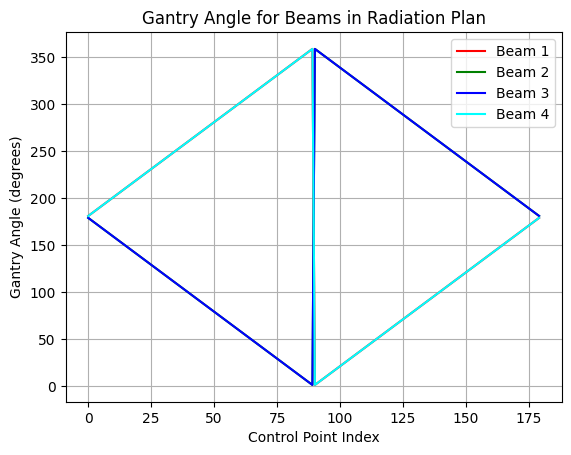

In [5]:
Beams = [beam for beam in RP_Files[0].BeamSequence # only 1 radiation plan file
         if beam.TreatmentDeliveryType.upper() == "TREATMENT"] # only consider treatment beams

gantry_angles = np.full((len(Beams), len(Beams[0].ControlPointSequence)), np.nan) # pre-allocating

for i, beam in enumerate(Beams):
    for j, controlpoint in enumerate(beam.ControlPointSequence):
        try:
            gantry_angles[i, j] = controlpoint.GantryAngle
        except:
            print(f"Skipped gantry angle for beam {i} control point {j}")

colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']

for i in range(np.shape(gantry_angles)[0]):
    plt.plot(gantry_angles[i], label=f"Beam {i+1}", color = colours[i])

plt.legend()
plt.xlabel("Control Point Index")
plt.ylabel("Gantry Angle (degrees)")
plt.title("Gantry Angle for Beams in Radiation Plan")
plt.grid(True)
plt.show()

### Plot 2D view of MLCs (Multi-Leaf Collimators) for one control point

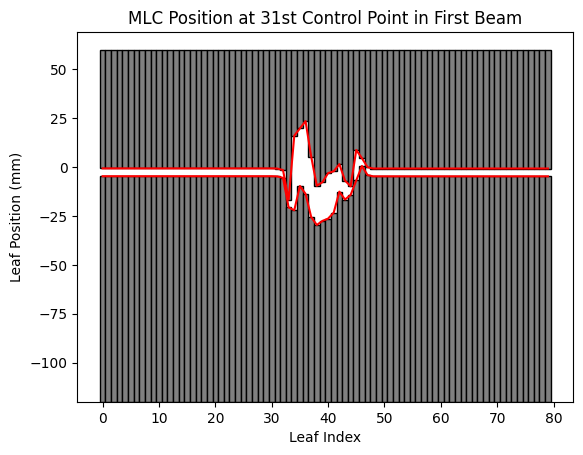

In [6]:
Beams = [beam for beam in RP_Files[0].BeamSequence # only 1 radiation plan file
         if beam.TreatmentDeliveryType.upper() == "TREATMENT"] # only consider treatment beams

beam = Beams[0] # only looking at beam 1 for now

controlpoint = beam.ControlPointSequence[30] # only looking at one control point for now

for device in controlpoint.BeamLimitingDevicePositionSequence:
    if device.RTBeamLimitingDeviceType == "MLCX":
        MLC_positons = device.LeafJawPositions
        MLC_DOWN = MLC_positons[:len(MLC_positons)//2]
        MLC_UP = MLC_positons[len(MLC_positons)//2:]
        plt.plot(MLC_DOWN, color = 'red')
        plt.plot(MLC_UP, color = 'red')
        min_height = -120
        plt.bar(np.arange(len(MLC_DOWN)), height = [leaf - min_height for leaf in MLC_DOWN], width=1.0, bottom=min_height, color='grey', edgecolor = 'black')
        max_height = 60
        plt.bar(np.arange(len(MLC_UP)), height = [max_height - leaf for leaf in MLC_UP], width=1.0, bottom = MLC_UP, color = 'grey', edgecolor = 'black')
        plt.xlabel('Leaf Index')
        plt.ylabel('Leaf Position (mm)')
        plt.title(f"MLC Position at 31st Control Point in First Beam")

        



### Plot the MUs as a function of control point

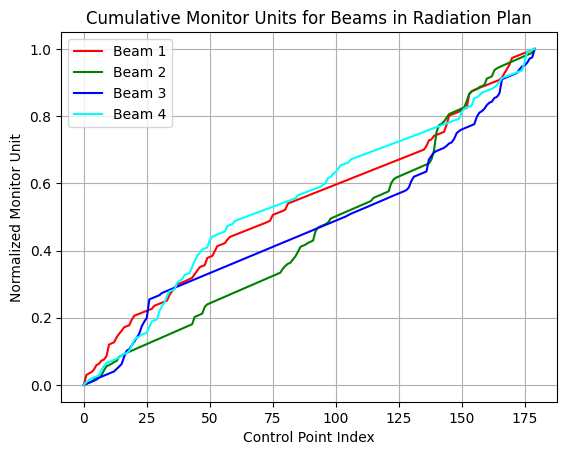

In [7]:
Beams = [beam for beam in RP_Files[0].BeamSequence # only 1 radiation plan file
         if beam.TreatmentDeliveryType.upper() == "TREATMENT"] # only consider treatment beams

monitor_units = np.full((len(Beams), len(Beams[0].ControlPointSequence)), np.nan) # pre-allocating

for i, beam in enumerate(Beams):
    for j, controlpoint in enumerate(beam.ControlPointSequence):
        monitor_units[i, j] = controlpoint.CumulativeMetersetWeight
        if monitor_units[i, j] == 1:
            monitor_units[i, j:] = 1
            break

colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']

for i in range(np.shape(monitor_units)[0]):
    plt.plot(monitor_units[i], label=f"Beam {i+1}", color = colours[i])

plt.legend()
plt.xlabel("Control Point Index")
plt.ylabel("Normalized Monitor Unit")
plt.title("Cumulative Monitor Units for Beams in Radiation Plan")
plt.grid(True)
plt.show()

### Plot the slice at isocentre of the CT in all three planes (coronal, sagittal and axial) labeled properly

[-256.  -171.3 -201. ]
[  0. 100.  30.]
[1. 1. 1.]
[256 271 231]


Text(1642.8692810457517, 0.5, 'Z (Voxels)')

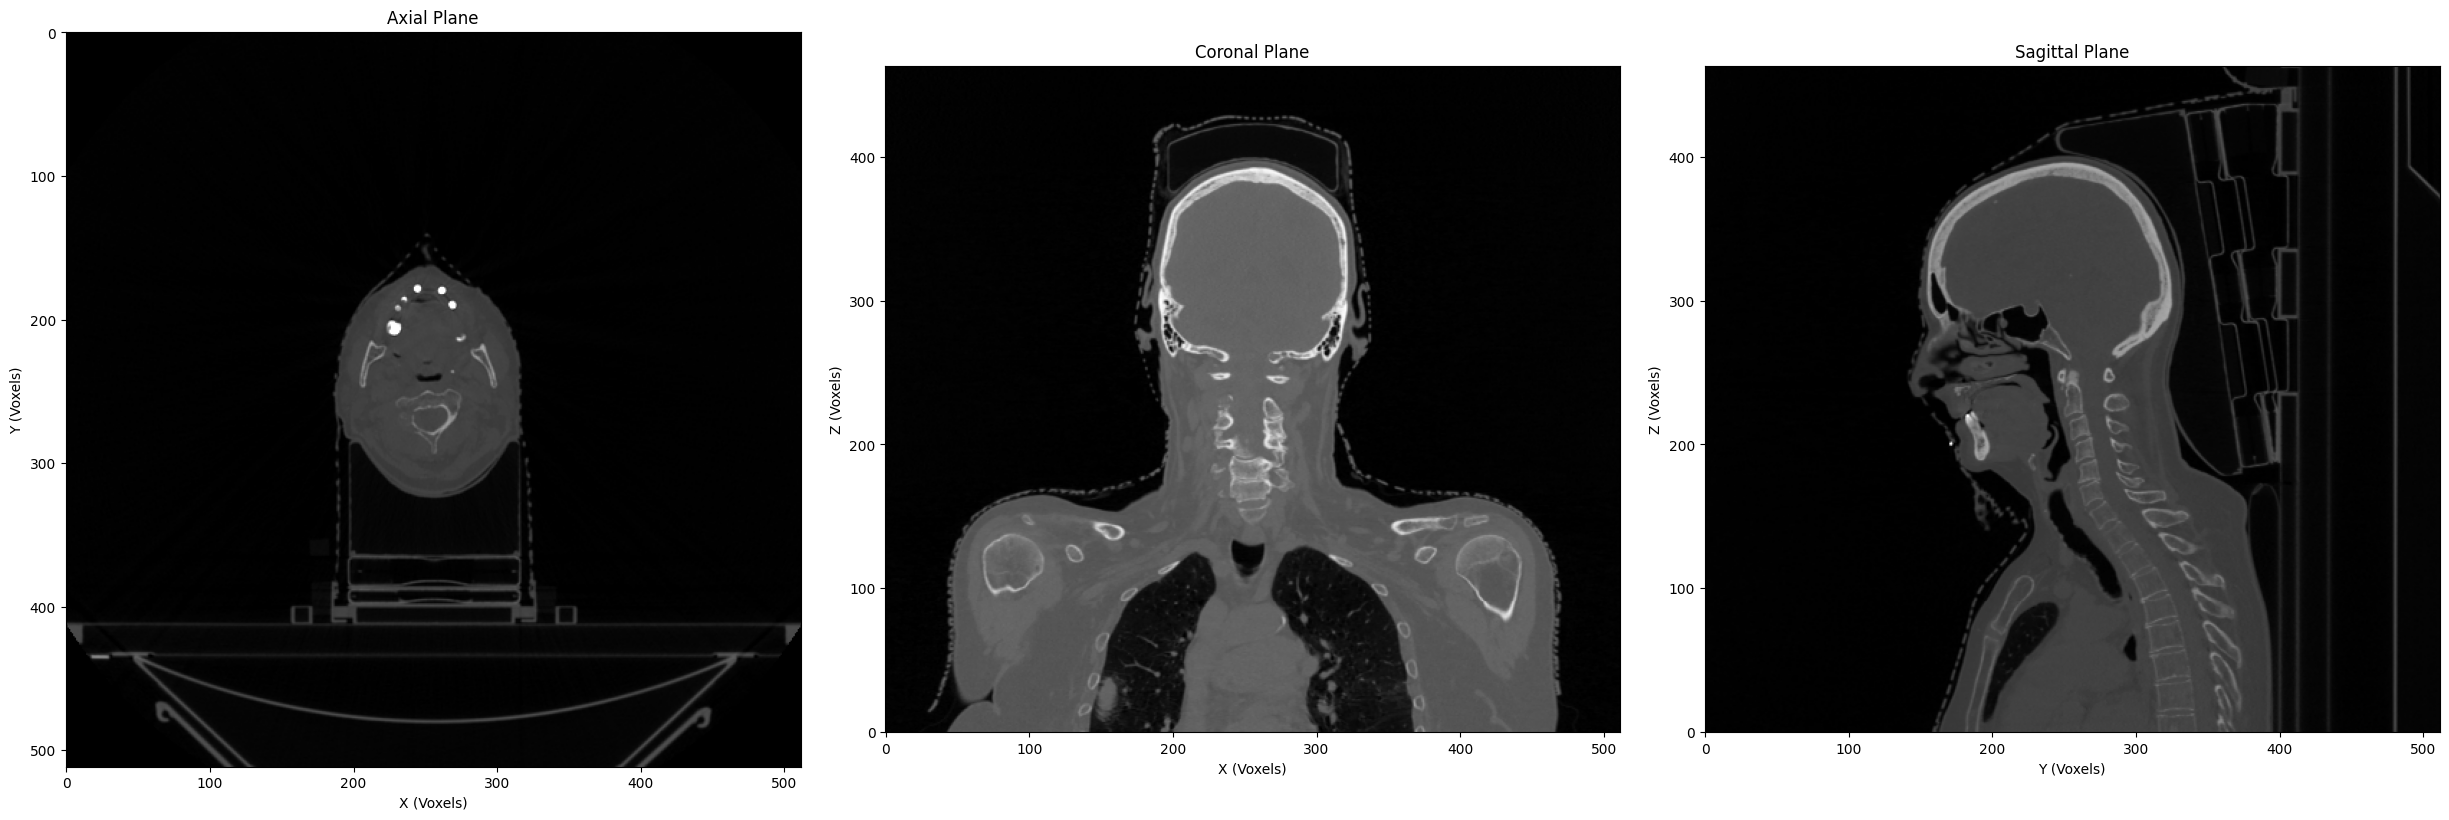

In [ ]:
Sorted_CT_Files = sorted(CT_Files, key=lambda file: float(file.ImagePositionPatient[2])) # sort files by z-axis. increasing towards the head
# anatomical orientation type (0010,2210) absent so z-axis is increasing towards the head of the patient

CT_Images = np.stack([slice.pixel_array for slice in Sorted_CT_Files], axis = 2) # make 3d matrix in [y x z]
CT_Images = np.transpose(CT_Images, (1, 0, 2)) # make it [x y z]

pixel_spacing = Sorted_CT_Files[0].PixelSpacing # pixel spacing in mm, [y x]
slice_thickness = Sorted_CT_Files[0].SliceThickness # slice thickness in mm [z]
voxel_spacing = np.array([pixel_spacing[1], pixel_spacing[0], slice_thickness]) # [x y z]
origin = np.array(Sorted_CT_Files[0].ImagePositionPatient) # origin in mm [x y z]
print(origin)

Isocentre_Pos = np.array(RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition) # get isocentre position in mm [x y z]
print(Isocentre_Pos)
print(voxel_spacing)
# print(f"({Isocentre_Pos[2]}-{origin[2]})/{voxel_spacing[2]}")
Isocentre_Pos = np.round((Isocentre_Pos - origin)/voxel_spacing).astype(int)
print(Isocentre_Pos)

# Isocentre_Pos = np.array(RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition) # get isocentre position in mm [x y z]


fig, axs = plt.subplots(1, 3, figsize=(25,25))
plt.tight_layout(pad=3.0)

axs[0].imshow(CT_Images[:, :, Isocentre_Pos[2]].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1]) # aspect = dy/dx
# axs[0].imshow(CT_Images[:, :, 230].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1])
axs[0].set_title('Axial Plane')
axs[0].set_xlabel('X (Voxels)')
axs[0].set_ylabel('Y (Voxels)')

axs[1].imshow(CT_Images[:, Isocentre_Pos[1], :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
# axs[1].imshow(CT_Images[:, 256, :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
axs[1].set_title('Coronal Plane')
axs[1].set_xlabel('X (Voxels)')
axs[1].set_ylabel('Z (Voxels)')

axs[2].imshow(CT_Images[Isocentre_Pos[0], :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
# axs[2].imshow(CT_Images[256, :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
axs[2].set_title('Sagittal Plane')
axs[2].set_xlabel('Y (Voxels)')
axs[2].set_ylabel('Z (Voxels)')

### Overlay the contours of the relevant structures on the image plots

In [9]:
def mm_to_voxel(mm_coords, origin, spacing):
    return np.round((mm_coords-origin)/spacing).astype(int)

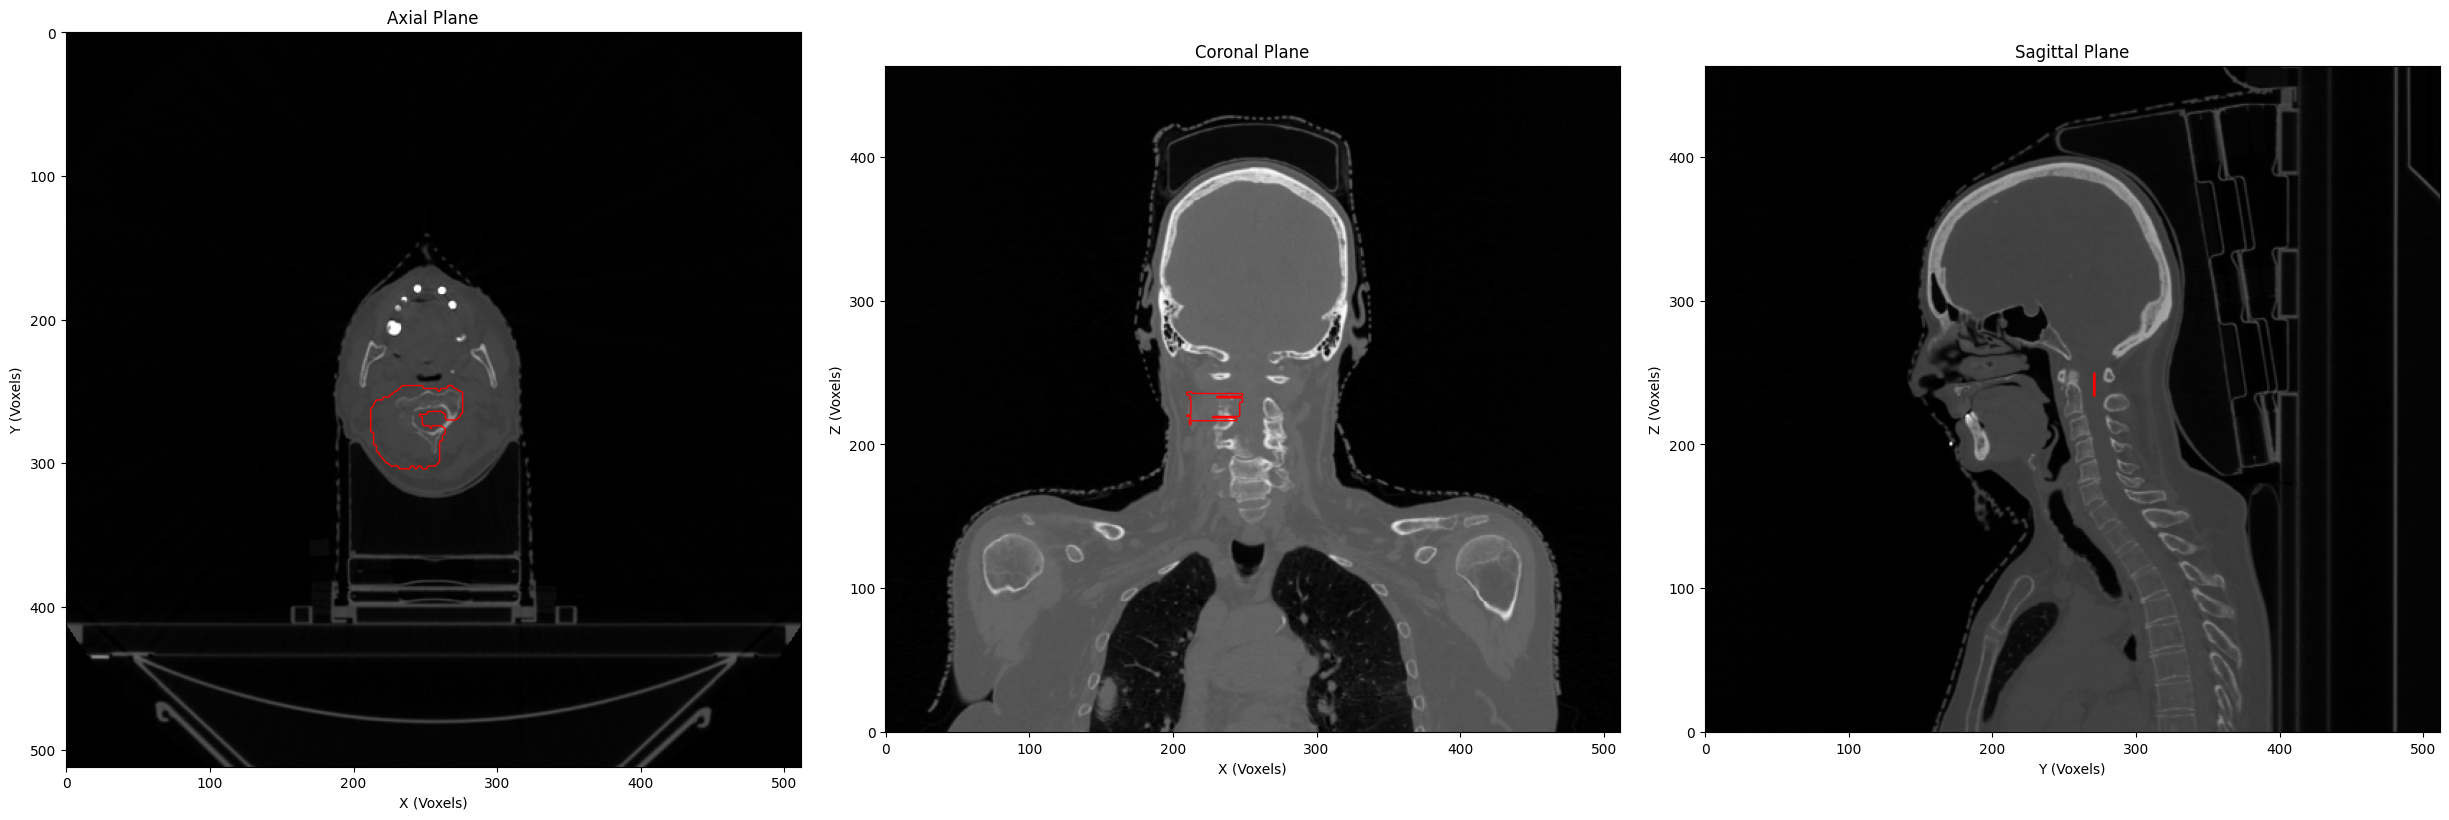

In [55]:
# plot stuff from before
fig, axs = plt.subplots(1, 3, figsize=(25,25))
plt.tight_layout(pad=3.0)

axs[0].imshow(CT_Images[:, :, Isocentre_Pos[2]].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1]) # aspect = dy/dx
# axs[0].imshow(CT_Images[:, :, 230].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1])
axs[0].set_title('Axial Plane')
axs[0].set_xlabel('X (Voxels)')
axs[0].set_ylabel('Y (Voxels)')

axs[1].imshow(CT_Images[:, Isocentre_Pos[1], :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
# axs[1].imshow(CT_Images[:, 256, :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
axs[1].set_title('Coronal Plane')
axs[1].set_xlabel('X (Voxels)')
axs[1].set_ylabel('Z (Voxels)')

axs[2].imshow(CT_Images[Isocentre_Pos[0], :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
# axs[2].imshow(CT_Images[256, :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
axs[2].set_title('Sagittal Plane')
axs[2].set_xlabel('Y (Voxels)')
axs[2].set_ylabel('Z (Voxels)')

Contour_Sequence = RS_Files[0].ROIContourSequence

ROI_Names = {ROI.ROINumber: 
             ROI.ROIName for ROI in RS_Files[0].StructureSetROISequence}

# Target_Structures = ["1PTV3000", "SpinalCord"]
Target_Structures = ["1PTV3000"]
Target_Numbers = np.full(len(Target_Structures), np.nan)

for i, structure in enumerate(Target_Structures):
    for Number, Name in ROI_Names.items():
        if structure.upper() in Name.upper():
            Target_Numbers[i] = Number
            break

for Number in Target_Numbers:
    for ROI in Contour_Sequence:
        if Number == ROI.ReferencedROINumber:
            Contour_Data = ROI.ContourSequence
    
    contour_points = np.array([]).reshape(0,3)
    for Contour in Contour_Data:
        contour_points_mm = np.array(Contour.ContourData).reshape(-1, 3) # (n, 3) 3 columns in n rows. in mm
        contour_points_slice = np.array([mm_to_voxel(p, origin, voxel_spacing) for p in contour_points_mm])
        contour_points = np.vstack([contour_points, contour_points_slice])
        # if contour_points_slice[0, 2] == Isocentre_Pos[2]: # when on isocentre slice
        #     x_pts, y_pts = contour_points_slice[:, 0], contour_points_slice[:, 1]
        #     axs[0].plot(x_pts, y_pts, 'r-', linewidth = 1)

    contour_axial = contour_points[contour_points[:, 2] == Isocentre_Pos[2]] # collect points when on isocentric axial plane
    x_pts, y_pts = contour_axial[:, 0], contour_axial[:, 1]
    axs[0].plot(x_pts, y_pts, 'r-', linewidth = 1)

    contour_coronal = contour_points[contour_points[:, 1] == Isocentre_Pos[1]] # collect points when on isocentric coronal plane
    mask = np.zeros((CT_Images[:,0,:].shape)) # pre-allocate mask
    rr, cc = polygon(contour_coronal[:, 2], contour_coronal[:, 0]) # , shape=mask.shape
    mask[rr, cc] = 1
    contours = find_contours(mask, level=0.5)
    # contour = max(contours, key = lambda x: len(x))
    contours = sorted(contours, key = lambda x: len(x))
    axs[1].plot(contours[-1][:, 1], contours[-1][:, 0], 'r-', linewidth=1)
    # for contour in contours:
    #     axs[1].plot(contour[:, 1], contour[:, 0], 'r-', linewidth=1)

    # x_pts, z_pts = contour_coronal[:,0], contour_coronal[:,2]
    # axs[1].plot(x_pts, z_pts, 'r-', linewidth = 1)

    contour_sagittal = contour_points[contour_points[:, 0] == Isocentre_Pos[0]] # collect points when on isocentric sagittal plane
    mask = np.zeros((CT_Images[:,0,:].shape)) # pre-allocate mask
    rr, cc = polygon(contour_coronal[:, 2], contour_coronal[:, 1]) # , shape=mask.shape
    mask[rr, cc] = 1
    contours = find_contours(mask, level=0.5)
    contours = sorted(contours, key = lambda x: len(x))
    axs[2].plot(contours[-1][:, 1], contours[-1][:, 0], 'r-', linewidth=1)
    # y_pts, z_pts = contour_sagittal[:,1], contour_sagittal[:,2]
    # axs[2].plot(y_pts, z_pts, 'r-', linewidth = 1)

    


In [42]:
CT_Images[:,0,:].shape

(512, 464)

In [43]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(512, 464))

In [29]:
test = contour_coronal[:, 2]

In [25]:
np.zeros(contour_coronal.shape)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [38]:
RS_Files[0].ROIContourSequence[2].ContourSequence[0]

(3006,0016)  Contour Image Sequence  1 item(s) ---- 
   (0008,1150) Referenced SOP Class UID            UI: CT Image Storage
   (0008,1155) Referenced SOP Instance UID         UI: 1.2.752.243.1.1.20250509103511308.2810.85480
   ---------
(3006,0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
(3006,0046) Number of Contour Points            IS: '55'
(3006,0048) Contour Number                      IS: '0'
(3006,0050) Contour Data                        DS: Array of 165 elements

In [ ]:
RS_Files[0].StructureSetROISequence[2]

(3006,0022) ROI Number                          IS: '3'
(3006,0024) Referenced Frame of Reference UID   UI: 1.2.752.243.1.1.20250509103510898.7000.45325
(3006,0026) ROI Name                            LO: 'SpinalCord'
(3006,0036) ROI Generation Algorithm            CS: 'SEMIAUTOMATIC'